# 2.3. Get Your Data Machine Learning Ready for Classification: Data Wrangling

## Preparing the Data

### **Table of Contents**

- [1. Data Import](#1-data-import)  
- [2. Data Wrangling](#2-data-wrangling)  
  - [2.1 Response Variable Distribution](#21-response-variable-distribution)  
  - [2.2 Rare Classes in Categorical Features, Duplicated Observations and Non-Informative Features](#22-rare-classes-in-categorical-features-duplicated-observations-and-non-informative-features)  
    - [2.2.1 Fix Inconsistent Labels](#221-fix-inconsistent-labels)  
    - [2.2.2 Address Rare Categories](#222-address-rare-categories)  
    - [2.2.3 Eliminate Duplicates](#223-eliminate-duplicates)  
    - [2.2.4 Remove Non-informative Features](#224-remove-non-informative-features)  
  - [2.3 Addressing Missingness (Part I)](#23-addressing-missingness-part-i)  
    - [2.3.1 Exclude Variables with Excessive Missingness](#231-exclude-variables-with-excessive-missingness)  
    - [2.3.2 Removing Observations with Missing Values](#232-removing-observations-with-missing-values)  
- [3. Data Splitting](#3-data-splitting)  
  - [3.1 Full Data to Training and Testing](#31-full-data-to-training-and-testing)  
  - [3.2 Cohort-Based Splitting](#32-cohort-based-splitting)  
  - [3.3 Method Comparison](#33-method-comparison)  
- [4. Adressing Missingness, Part II - Data Imputation](#4-adressing-missingness-part-ii---data-imputation)  


<a id="1"></a>
## 1 Data Import

In Course 1, Module 3: *Magic Pandas Library: Mastering Higher Education Data Preparation and Analysis*, we learned how to merge data that originated from multiple sources accross campus. The High School, Enrollment, Admissions, Course and Completion datasets all provide valuable information to assist us in our effort to predict student metrics in future semesters. As you recall, we've selected a subset of the variables from these data to include in the modeling phase. These include:
1. Academic Performance Data

      - Available at time of admission: high school GPAs

      - Available at time of modeling: units attempted, completed and DFW, and available postsecondary GPAs  
2. Demographic Data
      - Gender, ethnicity, first gen status

3. The target variable, **SEM_3_STATUS**, a qualitative variable coded as follows:

| Code | Meaning |
|---|---|
|E |Enrolled |
|N |Not Enrolled |
|G |Graduated |


Let's load the necessary Python libraries to import the data and start to process it for analysis:

In [19]:
import pandas as pd
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

Now let's import the **ml_data** data we've curated. Then, by typing the name we assign it, we can scope out the top and bottom 5 rows of the DataFrame and view its basic attributes in detail:

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
file_path = '/content/drive/MyDrive/projects/Applied-Data-Analytics-For-Higher-Education-Course-2/data/student_academics_data.csv'

df = pd.read_csv(file_path)
display(df.head())

,SID,COHORT,RACE_ETHNICITY,GENDER,FIRST_GEN_STATUS,FAMILY_INCOME,HS_GPA,HS_MATH_GPA,HS_ENGL_GPA,COLLEGE,UNITS_ATTEMPTED_1,UNITS_ATTEMPTED_2,UNITS_COMPLETED_1,UNITS_COMPLETED_2,DFW_UNITS_1,DFW_UNITS_2,GPA_1,GPA_2,GPA_3,SEM_1_STATUS,SEM_2_STATUS,SEM_3_STATUS
0,UHDOP5522,Fall 2020,Asian,Female,Continuing Generation,NaN,3.720,3.2,3.400,Visual & Performing Arts,15.0,14.0,15.0,15.0,0.0,0.0,4.000000,3.785714,4.0,E,E,E
1,UHE842CU6,Fall 2021,Black or African American,Female,Continuing Generation,NaN,3.189,2.6,3.750,Visual & Performing Arts,12.0,12.0,12.0,12.0,3.0,4.0,3.000000,2.500000,1.5,E,E,E
2,UHJFT1JAB,Fall 2018,Asian,Female,Continuing Generation,NaN,3.625,3.4,3.500,Visual & Performing Arts,15.0,15.0,15.0,16.0,0.0,0.0,3.800000,3.600000,3.6,E,E,E
3,UHKF05TAF,Fall 2018,Hispanic,Female,First Generation,NaN,3.606,3.0,3.375,Letters & Humanities,16.0,9.0,7.0,3.0,9.0,9.0,1.562500,1.000000,2.5,E,E,E
4,UHKKQ8UY5,Fall 2021,Hispanic,Male,Continuing Generation,50K<,3.536,2.5,2.625,Letters & Humanities,13.0,13.0,13.0,13.0,0.0,0.0,3.538462,3.769231,3.4,E,E,E


## 2. Data Wrangling

Data availability is a necessary condition for data analysis, but it is not sufficient. There are a number of modifications we need to make to the data to prepare it for machine learning. The process of preparing the data for exploration and modeling is known as **data wrangling**, and will be performed here.
To answer Shontelle's question, we need to build a model using cohorts for which term 3 grade data has already been collected. Thus our response variable will be based on the SEM_3_STATUS variable. Let's dig deeper.

<a id="21"></a>

### 2.1 Response Variable Distribution

Recall that this DataFrame consists of three cohorts: Fall 2021, Fall 2022 and Fall 2023. The cohort sizes may be identified as follows:

In [22]:
df['COHORT'].value_counts()

,count
COHORT,
Fall 2022,5363
Fall 2019,5170
Fall 2018,4954
Fall 2020,4910
Fall 2021,4866


The code below groups the retention DataFrame by 'COHORT' and 'SEM_3_STATUS' columns, counts the number of occurrences for each category, and resets the index, renaming the count column to 'COUNTS'.


In [23]:
df[['COHORT', 'SEM_3_STATUS']].groupby(['COHORT', 'SEM_3_STATUS']).size().reset_index(name='COUNTS')

,COHORT,SEM_3_STATUS,COUNTS
0,Fall 2018,E,4307
1,Fall 2018,N,647
2,Fall 2019,E,4583
3,Fall 2019,N,587
4,Fall 2020,E,4239
5,Fall 2020,N,671
6,Fall 2021,E,4133
7,Fall 2021,N,733
8,Fall 2022,E,4540
9,Fall 2022,N,823


<a id="22"></a>
### 2.2 Rare Classes in Categorical Features, Duplicated Observations and Non-Informative Features.

Let's take a look at the distribution of values in our non-numerical columns. If it turns out that there are some values that are rare, they could cause issues with our downstream data processing. One way to avoid this is to consolidate rare classes into one. Note that consolidating or dropping variables is not a reflection of their importance or relevance to the analysis; instead they highlight one of the limitations of machine learning and the importance of human oversight to create a legitimate representation of the truth.

Inspect the unique values and their counts for the categorical columns to identify any anomalies or labels that need fixing.



In [24]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    display(f"Value counts for column: {col}")
    display(df[col].value_counts())

'Value counts for column: SID'

,count
SID,
P9CHKVJ7X,2
0W430472L,2
FS2AVPW1M,2
FY9HZPJ60,2
MWYLJAF1S,2
...,...
Z8UOMJIWF,1
Z8UOB0XEW,1
Z8UITDMUC,1


'Value counts for column: COHORT'

,count
COHORT,
Fall 2022,5363
Fall 2019,5170
Fall 2018,4954
Fall 2020,4910
Fall 2021,4866


'Value counts for column: RACE_ETHNICITY'

,count
RACE_ETHNICITY,
Hispanic,12359
Asian,5995
White,3481
Two or More Races,1190
Nonresident alien,925
Black or African American,911
Unknown,318
Native Hawaiian or Other Pacific Islander,61
American Indian or Alaska Native,23


'Value counts for column: GENDER'

,count
GENDER,
Female,15119
Male,10014
Nonbinary,38
Female,26
female,26
Male,20
male,20


'Value counts for column: FIRST_GEN_STATUS'

,count
FIRST_GEN_STATUS,
Continuing Generation,15735
First Generation,7384
Unknown,2144


'Value counts for column: FAMILY_INCOME'

,count
FAMILY_INCOME,
>150K,1129
50K<,1088
100K to 149K,1057
50K to 99K,1022


'Value counts for column: COLLEGE'

,count
COLLEGE,
Health & Human Services,4581
Engineering & Technology,4051
General Studies,3952
Letters & Humanities,3707
Natural and Mathematical Sciences,2868
Business Administration,2840
Visual & Performing Arts,2752
Education & Leadership,512


'Value counts for column: SEM_1_STATUS'

,count
SEM_1_STATUS,
E,25263


'Value counts for column: SEM_2_STATUS'

,count
SEM_2_STATUS,
E,24111
N,1152


'Value counts for column: SEM_3_STATUS'

,count
SEM_3_STATUS,
E,21802
N,3461


Our initial step involves handling duplicate student SIDs, which will be addressed shortly. Next, we will clean the 'GENDER' column by standardizing inconsistent labels, applying consistent capitalization, and removing leading/trailing whitespace. Rare categories, such as 'Nonbinary' within 'GENDER', will be consolidated or removed. Lastly, we will process the 'RACE_ETHNICITY' feature, combining the 'Unknown', 'Native Hawaiian or Other Pacific Islander', and 'American Indian or Alaska Native' classes into a single 'Other' category.

#### 2.2.1 Fix Inconsistent Labels.

Fix inconsistent labels in the **GENDER** feature by converting all entries to a consistent case and removing leading/trailing spaces.

In [25]:
df['GENDER'] = df['GENDER'].str.strip().str.capitalize()
display(df['GENDER'].value_counts())

,count
GENDER,
Female,15171
Male,10054
Nonbinary,38


##### 2.2.2 Address Rare Categories

Drop the rare Non-binary class in **GENDER**:

In [26]:
df = df[df['GENDER'] != 'Non-binary']

For **RACE_ETHNICITY** compbine Unknown, Native Hawaiian or Other Pacific Islander, and American Indian or Alaska Native into the category Other


In [27]:
df['RACE_ETHNICITY'] = df['RACE_ETHNICITY'].replace(['Unknown', 'Native Hawaiian or Other Pacific Islander', 'American Indian or Alaska Native'], 'Other')

##### 2.2.3 Eliminate Duplicates

Check for duplicate rows in the DataFrame.

In [28]:
df.duplicated().sum()

np.int64(51)

Drop duplicate rows from the DataFrame.



In [29]:
df.drop_duplicates(inplace=True)
display(df.duplicated().sum())

np.int64(0)

##### 2.2.4 Remove Non-informative Features.

##### Drop unnecessary or redundant columns outside of analysis scope

In [30]:
df.drop(['HS_GPA', 'SEM_1_STATUS', 'SEM_2_STATUS'], axis=1, inplace=True)

<a id="4"></a>
## 3. Addressing Missingness, Part I

As mentioned previously, an essential data preprocessing step for modeling in scikit learn is accounting for missingness in our observations. Scikit learn models will not run with missing data, so we need to decide how to deal with it.
Let's investigate missingness in our dataset, and use that to determine the most effective way to proceed:

To check for missing values in a Pandas DataFrame, we can use the command `df.isnull().sum()`. The output of this command shows a large number of missing values in our data. This is expected, as high school data is not available for many students. While missing data can sometimes be ignored during exploratory data analysis, it must be addressed for predictive modeling using libraries like statsmodels and scikit-learn, which require complete data.



In [31]:
display(df.isnull().sum())

,0
SID,0
COHORT,0
RACE_ETHNICITY,0
GENDER,0
FIRST_GEN_STATUS,0
FAMILY_INCOME,20919
HS_MATH_GPA,359
HS_ENGL_GPA,359
COLLEGE,0
UNITS_ATTEMPTED_1,130


Before proceeding, we need to decide how to handle these missing values. We have three main options:

1.  **Exclude variables with excessive missingness:** Remove entire columns that have missing values above a threshold
2.  **Remove observations:** Delete all rows that contain any missing values.
3.  **Impute values:** Fill in missing values with estimated or plausible values.

In Part I, we will focus on 1. and 2. as necessary and 3. will be adressed after we split the data in section 2.4



## Addressing Missing Values: Why Imputation Follows Data Splitting

Handling missing data is a key step in preparing your dataset for machine learning. Here we identified missing values and dropped columns with over 50% missing data, which impacts how duplicates are found.

### Impact of Dropping High Missingness Columns

Dropping columns with a high percentage of missing values affects subsequent data cleaning steps, including duplicate detection. If this step were performed *after* splitting the data, the training and testing sets might have different sets of columns dropped based on their individual missingness profiles. This could lead to inconsistencies between the training and testing data, potentially impacting model performance and interpretability. Performing this removal *before* splitting ensures that both the training and testing sets have the same set of features based on the overall data's missingness patterns. This consistent feature set then allows for more reliable duplicate detection based on the remaining, more complete columns across the entire dataset before the split.

### Imputation and Data Leakage

After handling high missingness and duplicates, remaining missing values need imputation. To prevent **data leakage**, it's vital to impute *after* splitting data into training and testing sets.

Data leakage occurs when test set information influences the training process. If imputation values (like means) are calculated using the entire dataset before splitting, information from the test set leaks into the training set.

**Imputing After Splitting:**

*   Calculate imputation values (e.g., mean) using *only* the training data.
*   Fill missing values in the training set using these training-based values.
*   Fill missing values in the testing set using the *same* values calculated from the training set.

This approach ensures the model learns to handle missing data based only on the training set's patterns, accurately reflecting how it would perform on new, unseen data. Imputing before splitting can lead to an overestimation of model performance on the test set.

Therefore, imputing missing values after splitting is crucial for preventing data leakage and getting a realistic measure of your model's ability to generalize.

### 3.1 Exclude variables with excessive missingness.

Identify columns with more than 50% missing values and drop them from the dataframe.



In [32]:
missing_values_count = df.isnull().sum()
total_rows = len(df)
columns_to_drop = missing_values_count[missing_values_count / total_rows > 0.5].index.tolist()
df.drop(columns=columns_to_drop, inplace=True)
display(f"Number of remaining columns: {df.shape[1]}")
display(df.head())

'Number of remaining columns: 18'

,SID,COHORT,RACE_ETHNICITY,GENDER,FIRST_GEN_STATUS,HS_MATH_GPA,HS_ENGL_GPA,COLLEGE,UNITS_ATTEMPTED_1,UNITS_ATTEMPTED_2,UNITS_COMPLETED_1,UNITS_COMPLETED_2,DFW_UNITS_1,DFW_UNITS_2,GPA_1,GPA_2,GPA_3,SEM_3_STATUS
0,UHDOP5522,Fall 2020,Asian,Female,Continuing Generation,3.2,3.400,Visual & Performing Arts,15.0,14.0,15.0,15.0,0.0,0.0,4.000000,3.785714,4.0,E
1,UHE842CU6,Fall 2021,Black or African American,Female,Continuing Generation,2.6,3.750,Visual & Performing Arts,12.0,12.0,12.0,12.0,3.0,4.0,3.000000,2.500000,1.5,E
2,UHJFT1JAB,Fall 2018,Asian,Female,Continuing Generation,3.4,3.500,Visual & Performing Arts,15.0,15.0,15.0,16.0,0.0,0.0,3.800000,3.600000,3.6,E
3,UHKF05TAF,Fall 2018,Hispanic,Female,First Generation,3.0,3.375,Letters & Humanities,16.0,9.0,7.0,3.0,9.0,9.0,1.562500,1.000000,2.5,E
4,UHKKQ8UY5,Fall 2021,Hispanic,Male,Continuing Generation,2.5,2.625,Letters & Humanities,13.0,13.0,13.0,13.0,0.0,0.0,3.538462,3.769231,3.4,E


### 3.2 Removing Observations with Missing Values.

After addressing columns with excessive missingness, a decision must be made regarding the remaining missing values. While one option is to remove entire observations containing missing data to ensure completeness—a valid approach for many machine learning algorithms that require full datasets without missing values—in this notebook, we will instead pursue imputation, for teaching purposes. Imputation, which involves filling in missing values with estimated figures, is another common strategy to handle missingness, and it is the path we will take to retain as much of the original data as possible for our analysis.

<a id="3"></a>
## 4. Data Splitting


As mentioned in *Module 3: Explaining the Machine Learning Cycle Without Hyperparameter Tuning* we observed that a learning algorithm is only useful to the extent that we can confidently apply it to unseen data to make accurate predictions. The ability to generalize is measured by an investigation of model performance on a random sample of the full data called the test set. Before we explore or analyze our data it is imperative that we split it into a training and test set. This step will reintroduce us to Python's machine learning powerhouse, **[scikit learn](https://scikit-learn.org/stable/index.html)**.

<a id="31"></a>
#### 3.1 Full Data to Training and Testing

Data splitting is one of the most important steps of the machine learning cycle. We've all had instructors that, let's just say, provided alot of friendly *guidance* for what material would appear on an exam (they were pretty popular professors). Often this was in the form of a "practice exam". This led to a scenario where the exam was for all intents and purposes observed before exam day, and those who could memorize well were likely to achieve the most success. As much as stressed out college students might enjoy it, this arrangement does not facilitate genuine learning, which is demonstrated by the ability to accurately generalize concepts and constructs to new scenarios.  This is why we split data. So that instead of memorizing content and being tested on how well we can repeat it, we are attempting to learn the "how" and "why" behind the data generating process so that when new data comes from the process, we can legitimately demonstrate a deep level of understanding. Splitting the data into a train set an a test set, and not using the test set at all to learn patterns in the data will enable our model to demonstrate this deeper understanding. Let's load the **train_test_split** module from the scikit learn library and get our study on!

In [33]:
#Class for data splitting
from sklearn.model_selection import train_test_split

***Figure 1***: An example of an 80%-20% train-test split on a dataframe with 20 observations. Randomly sample 20% * 20 = 4 values to hold out for model testing: Observations 2,6,13 and 19.

![ih] (https://github.com/ksuaray/IRML---Regression-and-Classification/blob/MLCert-Sketches/MLCert%20Sketches%202/80-20-Xy.png?raw=true)


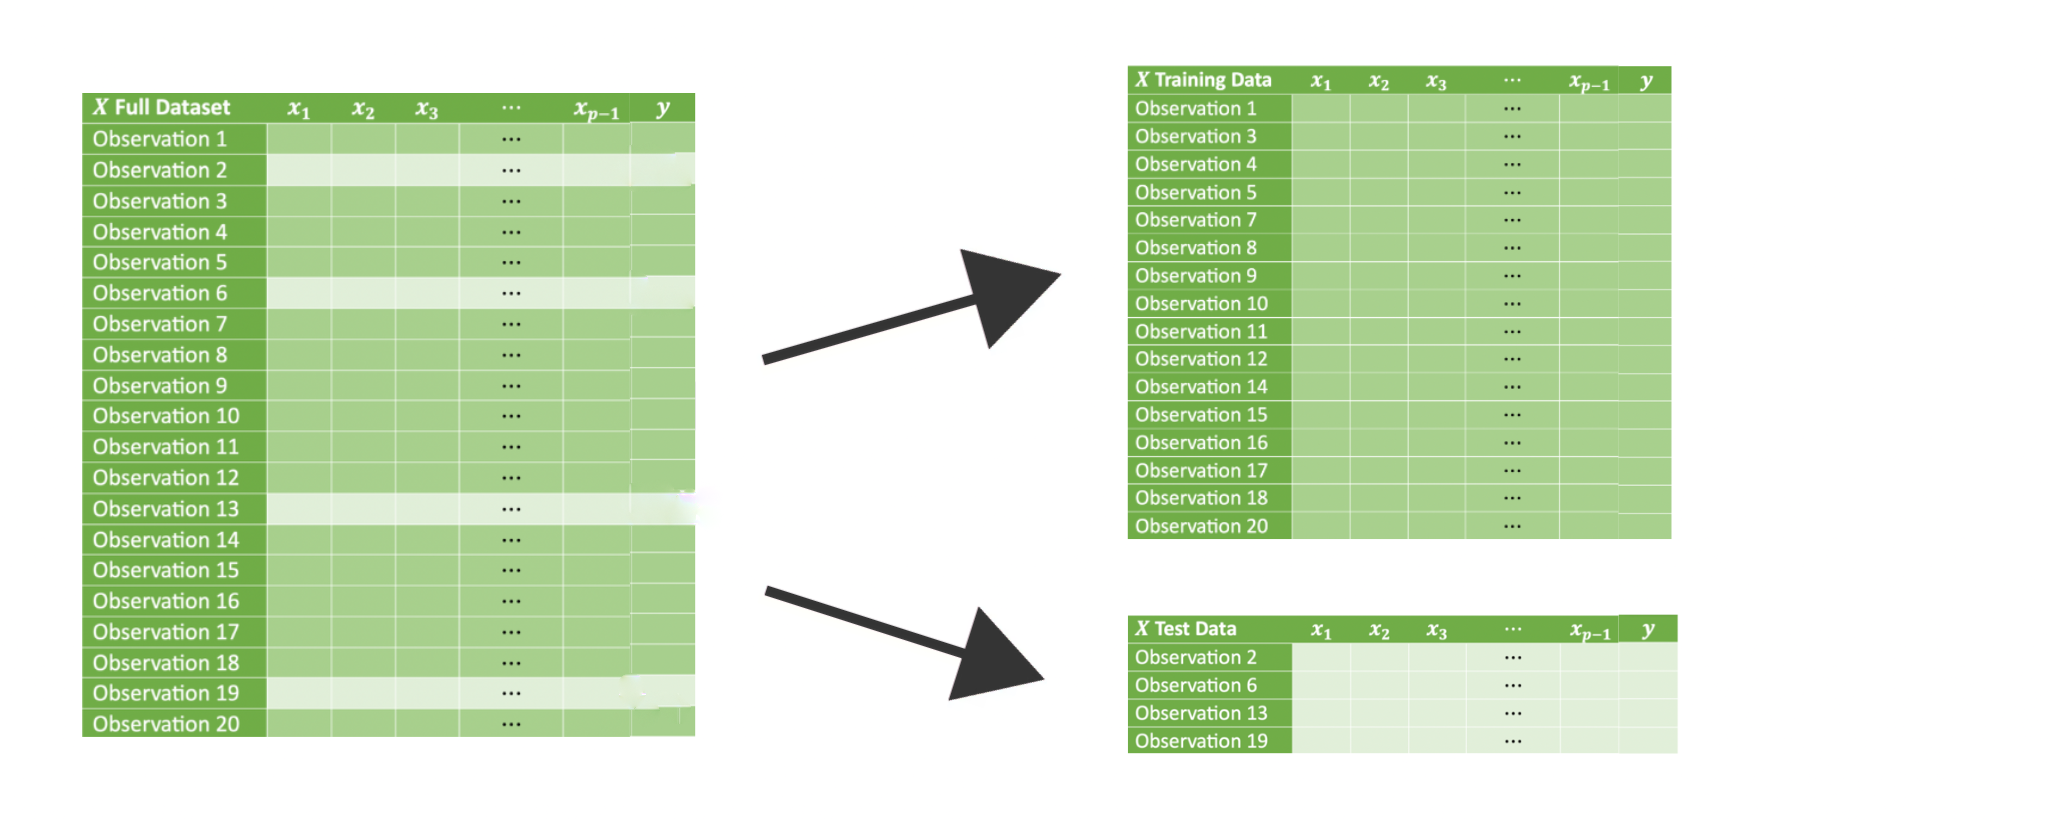

In [34]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.20, random_state=42)

display(f"Shape of training data: {df_train.shape}")
display(f"Shape of testing data: {df_test.shape}")

'Shape of training data: (20169, 18)'

'Shape of testing data: (5043, 18)'

From our original 25,212 observations, 25% \\(\times\\) 25,212 \\(\approxeq\\) 6303 will be reserved for model testing. To prevent *data leakage*, they will not be part of our data exploration or model fitting whatsoever; we don't want to peek at the test before exam day, right?

### 3.2 Cohort-Based Splitting

- Imagine you're trying to predict whether students in the **Fall 2022** cohort will drop out — but your model has only seen data from earlier semesters.

- This is a **real-world scenario**: using historical data to make future predictions.

- Instead of using a random mix of students, we deliberately separate the latest cohort (Fall 2022) to simulate **how well our model performs on new, unseen students**.

- This is known as **cohort-based splitting**, and it's a more realistic evaluation when time or group differences matter.


In [35]:
# Let's separate the test set to only include students from 'Fall 2022' cohort
df_test_cohort = df[df['COHORT'] == 'Fall 2022'].copy()

# The training set will include all students from earlier cohorts
df_train_cohort = df[df['COHORT'] != 'Fall 2022'].copy()

# Show shapes of both datasets
print(f"Training Data Shape (Cohort-Based): {df_train_cohort.shape}")
print(f"Testing Data Shape (Fall 2022 Cohort): {df_test_cohort.shape}")


Training Data Shape (Cohort-Based): (19850, 18)
Testing Data Shape (Fall 2022 Cohort): (5362, 18)


In this case, the training set includes all students **except** those in the Fall 2022 cohort. The test set contains **only** Fall 2022 students.

This allows us to test how well the model trained on past students performs on a **completely new group**. It's like training a tutor on last year's students and then seeing how well they guide this year's students.


In [36]:
# Let’s preview 3 rows from each set to understand the data better
print("Training Data Sample (Before Fall 2022):")
display(df_train_cohort.head(3))

print("\nTesting Data Sample (Only Fall 2022):")
display(df_test_cohort.head(3))


Training Data Sample (Before Fall 2022):


,SID,COHORT,RACE_ETHNICITY,GENDER,FIRST_GEN_STATUS,HS_MATH_GPA,HS_ENGL_GPA,COLLEGE,UNITS_ATTEMPTED_1,UNITS_ATTEMPTED_2,UNITS_COMPLETED_1,UNITS_COMPLETED_2,DFW_UNITS_1,DFW_UNITS_2,GPA_1,GPA_2,GPA_3,SEM_3_STATUS
0,UHDOP5522,Fall 2020,Asian,Female,Continuing Generation,3.2,3.40,Visual & Performing Arts,15.0,14.0,15.0,15.0,0.0,0.0,4.0,3.785714,4.0,E
1,UHE842CU6,Fall 2021,Black or African American,Female,Continuing Generation,2.6,3.75,Visual & Performing Arts,12.0,12.0,12.0,12.0,3.0,4.0,3.0,2.500000,1.5,E
2,UHJFT1JAB,Fall 2018,Asian,Female,Continuing Generation,3.4,3.50,Visual & Performing Arts,15.0,15.0,15.0,16.0,0.0,0.0,3.8,3.600000,3.6,E



Testing Data Sample (Only Fall 2022):


,SID,COHORT,RACE_ETHNICITY,GENDER,FIRST_GEN_STATUS,HS_MATH_GPA,HS_ENGL_GPA,COLLEGE,UNITS_ATTEMPTED_1,UNITS_ATTEMPTED_2,UNITS_COMPLETED_1,UNITS_COMPLETED_2,DFW_UNITS_1,DFW_UNITS_2,GPA_1,GPA_2,GPA_3,SEM_3_STATUS
9,UHNY4ZPLM,Fall 2022,Other,Female,Continuing Generation,3.833,3.800,Natural and Mathematical Sciences,15.0,14.0,15.0,15.0,0.0,0.0,3.333333,3.642857,2.400000,E
12,UI2LY561G,Fall 2022,Hispanic,Female,First Generation,3.500,3.667,Education & Leadership,15.0,14.0,15.0,11.0,0.0,3.0,3.600000,2.357143,3.000000,E
19,UIEH9V2LO,Fall 2022,Hispanic,Male,First Generation,3.667,3.500,Letters & Humanities,14.0,15.0,15.0,15.0,0.0,0.0,2.071429,3.600000,3.307692,E


## 3.3 Method Comparison

**Method 1: Random Split (train_test_split)**

Pros:

- Ensures that both the training and testing sets are representative of the overall data distribution.
- Simple to implement and a standard practice in machine learning.
- Avoids potential biases that could arise from non-random splits.

Cons:

- May not be ideal if one needs to evaluate the model's performance on a specific, future cohort.
- If there are significant differences between cohorts, a randomly split test set might not reflect real-world performance.

**Method 2: Cohort-Based Split (COHORT == 'Fall 2022')**

Pros:

- Provides a realistic evaluation of how the model would perform on a specific group, such as the most recent cohort.
- Allows you to assess the model's ability to generalize to a cohort that may have different characteristics.

Cons:

- The test set may not be representative of the overall data distribution if the chosen cohort is significantly different.
- If the chosen test cohort is significantly different from the training cohorts, the model's performance might appear worse than it actually is.
- Reduces the size of the training data, which could impact model performance, especially for smaller datasets.

**When to use which method:**

- Use random splitting when you want to build a model that generalizes well to new data from the same population.
- Use cohort-based splitting when you need to specifically evaluate your model's performance on a particular group or time period.

# 4 Adressing Missingness, Part II - Data Imputation



After splitting the data into training and testing sets, we need to make sure the datasets are **clean and complete** before we feed them into a machine learning model. Real-world data often contains **missing values** — cells that are empty or labeled as NaN (`Not a Number`). These can cause problems during training because most algorithms can’t handle missing values out-of-the-box.

Let’s walk through how to handle (or "impute") these missing values in a smart and consistent way.




We define a reusable Python function called `impute_missing_values` to clean our datasets by filling in missing values. This is important because most machine learning models cannot work with empty (NaN) values.

---

**Step 1 – Identify Missing Columns in Training Set**  
We use `isnull().sum()` to count the number of missing (NaN) values per column in `df_train`. Then we filter the columns that actually have missing values using `.index`.

---

**Step 2 – Impute Missing Values in `df_train`**  
We loop through each column with missing values:

- “For numeric columns (`int64`, `float64`), we replace missing values with the median.”
- “For categorical columns, we use the most frequent value (mode).”

---

**Step 3 – Identify Missing Columns in Testing Set**  
Similar to Step 1, but now for `df_test`.

---

**Step 4 – Impute Missing Values in `df_test` Using `df_train` Stats**  
Here’s the key detail: we don’t use `df_test` statistics to fill its own missing values.  
Instead, we use the median/mode from `df_train` to prevent data leakage.

---

**Step 5 – Apply to All Datasets**  
Finally, we apply the same imputation function to both the main train-test set and the cohort-based dataset (`df_train_cohort`, `df_test_cohort`).

---


In [37]:
def impute_missing_values(df_train, df_test):
  # Step 1: Identify columns with missing values in df_train
  missing_train = df_train.isnull().sum()
  cols_with_missing_train = missing_train[missing_train > 0].index

  # Step 2: Impute missing values in df_train
  for col in cols_with_missing_train:
      if df_train[col].dtype in ['int64', 'float64']:
          median_val = df_train[col].median()
          df_train[col].fillna(median_val, inplace=True)
      else:
          mode_val = df_train[col].mode()[0]
          df_train[col].fillna(mode_val, inplace=True)

   # Step 3: Identify columns with missing values in df_test
  missing_test = df_test.isnull().sum()
  cols_with_missing_test = missing_test[missing_test > 0].index

  # Step 4: Impute missing values in df_test using df_train stats
  for col in cols_with_missing_test:
      if df_test[col].dtype in ['int64', 'float64']:
          # Use median from df_train
          median_val_train = df_train[col].median()
          df_test[col].fillna(median_val_train, inplace=True)
      else:
          # Use mode from df_train
          mode_val_train = df_train[col].mode()[0]
          df_test[col].fillna(mode_val_train, inplace=True)


  return df_train, df_test

# Step 5: Apply to both main and cohort datasets
df_train, df_test = impute_missing_values(df_train, df_test)
df_train_cohort, df_test_cohort = impute_missing_values(df_train_cohort, df_test_cohort)

This code below checks whether any missing values remain after imputation. It uses `isnull().sum().sum()` to count all NaN values across the entire dataset. If the result is `0` for both `df_train_cohort` and `df_test_cohort`, it confirms that the imputation was successful and the data is now clean and ready for modeling.

In [38]:
# Verify no remaining missing values
display("Missing values in df_train after imputation:")
display(df_train_cohort.isnull().sum().sum())
display("Missing values in df_test after imputation:")
display(df_test_cohort.isnull().sum().sum())

'Missing values in df_train after imputation:'

np.int64(0)

'Missing values in df_test after imputation:'

np.int64(0)

## 5. Insights or Next Steps

*   The data wrangling steps have prepared the data for model training by handling duplicates, removing columns with excessive missing data, splitting the data, and imputing missing values in a leakage-aware manner.
*   The next steps would involve conducting Exploratory Data Analysis, further feature engineering, and selecting appropriate machine learning models for the retention prediction task.


## 6. Save the Training and Testing Dataset for Future Use.

In [39]:
location = '/content/drive/MyDrive/projects/Applied-Data-Analytics-For-Higher-Education-Course-2/data'

In [40]:
# Save df_train_cohort to a CSV file
df_train_cohort.to_csv(f'{location}/training.csv', index=False)

# Save df_test_cohort to a CSV file
df_test_cohort.to_csv(f'{location}/testing.csv', index=False)